In [1]:
# ! pip install pyarrow scikit-learn matplotlib sentencepiece pandas opencv-python

In [2]:
import torch
import cv2
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sentencepiece as spm
import matplotlib.pyplot as plt
import multiprocessing
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

if torch.backends.mps.is_available():  # Check for Apple Silicon GPU availability (requires PyTorch 1.12 or later)
    device = torch.device("mps")
elif torch.cuda.is_available():  # Check for NVIDIA GPU availability
    device = torch.device("cuda")
else:
    device = torch.device("cpu")  # Fall back to CPU

print(f"Using device: {device}")

Using device: mps


In [3]:
imageHeigh = 512
imageWidth = 1024
# imageHeigh = 128
# imageWidth = 128
# grid_H = 4
# grid_W = 4
grid_H = 8
grid_W = 16
num_classes = 3
B = 1
bbox_length = 8

Function Encoding annotation by Grid

In [4]:
def encodeAnnotationSmart(annotations, imageHeigh, imageWidth, grid_H, grid_W, B, bbox_length=8, device = 'cpu'):
        boxes = torch.zeros((grid_H, grid_W, B, bbox_length), dtype=torch.float32, device=device)

        cell_heigh = (imageHeigh/grid_H)
        cell_width = (imageWidth/grid_W)
        
        for _, object in annotations.iterrows():
            i =  int(object['y'] // cell_heigh)
            j =  int(object['x'] // cell_width)
            
            index =  int(torch.sum(boxes[i,j,...,0]).item())
           
            if index >= B :
                break;
            
            oneHotClass = torch.nn.functional.one_hot(
                torch.tensor(int(object['class']), dtype=torch.int64, device=device), 
                num_classes=3
            )

            # x = object['x']/imageWidth
            # y = object['y']/imageHeigh

            # y = (object['y']/cell_heigh) % 1
            # x = (object['x']/cell_width) % 1

            y = (object['y'] - i * cell_heigh) / cell_heigh
            x = (object['x'] - j * cell_width) / cell_width

            # radius = object['radius']/cell_heigh
            radius = object['radius']/imageHeigh
            
            box_data = torch.tensor([1,x, y, radius, object['orientation']], dtype=torch.float32, device=device)
            
            boxes[i, j, index, :5] = box_data
            boxes[i, j, index, 5:] = oneHotClass.float() 

        return boxes

IMage Draw and Preprocess


In [5]:
from matplotlib.patches import Circle
def preprocessImage(image, device):

     # Decode image from binary data
     image_pxl = cv2.imdecode(np.frombuffer(image, np.uint8), cv2.IMREAD_COLOR)
     image_pxl = cv2.cvtColor(image_pxl, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

     # Normalize pixel values
     image   = image_pxl / 255.0  # Scale pixels to [0, 1]
     
     # Manually normalize the image using specified means and stds
     # mean    = np.array([0.485, 0.456, 0.406])
     # std     = np.array([0.229, 0.224, 0.225])
     # image   = (image - mean) / std  # Apply normalization

     image = torch.tensor(image, dtype=torch.float32, device = device).permute(2, 0, 1)
     return image, image_pxl

def drawImage(source_image, output, grid_H, grid_W, hideUnconfident = False):
     # Use Matplotlib to display the image
     dpi = 100  # Dots per inch
     figsize = (1024 / dpi, 512 / dpi)  # Calculate figsize in inches to match the image's size

     plt.figure(figsize=figsize, dpi=dpi)
     plt.imshow(source_image)
     plt.axis('off')  # Hide the axes

     # Remove white borders
     plt.tight_layout(pad=0)

     # plt.show()
     # Specify the grid size
     image_H, image_W, _ = source_image.shape

     cell_heigh = (image_H/grid_H)
     cell_width = (image_W/grid_W)

     # Draw vertical lines for the grid
     for x in np.linspace(start=0, stop=image_W, num=grid_W+1):
          plt.axvline(x=x, color='black', linestyle='-', linewidth=0.5)

     # Draw horizontal lines for the grid
     for y in np.linspace(start=0, stop=image_H, num=grid_H+1):
          plt.axhline(y=y, color='black', linestyle='-', linewidth=0.5)

     ax = plt.gca()

     for i in range(output.shape[1]):  # Iterate over grid_H
          for j in range(output.shape[2]):  # Iterate over grid_W
               for g in range(output.shape[3]):  # Iterate over Objects
                    # y = output[0, i, j, g, 2].item() * image_H
                    # x = output[0, i, j, g, 1].item() * image_W

                    # y = (output[0, i, j, g, 2].item() + i) * cell_heigh
                    # x = (output[0, i, j, g, 1].item() + j) * cell_width

                    y = (output[0, i, j, g, 2].item()* cell_heigh) + i * cell_heigh
                    x = (output[0, i, j, g, 1].item()* cell_width) + j * cell_width

                    # radius = output[0, i, j,g, 3].item() * cell_heigh 
                    radius = output[0, i, j,g, 3].item() * image_H 

                    C = output[0, i, j, g, 0].item()
               
                    colour = torch.argmax(output[0, i, j, g, 5:]).item()

                    colours = ['white', 'blue', 'red',]
                    linewidth = 2
                    
                    if radius < 15 or radius > 25:
                         radius = 5
                    if x < 0:
                         x = 0
                    if x > image_W:
                         x = image_W
                    if y < 0:
                         y = 0
                    if y > image_H:
                         y = image_H
                    
                    if C <= 0:  
                         radius = 3
                         linewidth = 0.5
                         if hideUnconfident == True:
                              break;
                    # Draw the circle
                    circle = Circle((x, y), radius, color=colours[colour], linewidth=linewidth, fill=False)
                    ax.add_patch(circle)
                    if C > 0:
                         plt.text(x, y, f"{C:.2f}", color="white", ha='center', va='center')
     plt.show()

Load Data

In [6]:
def dump_images(df):
  for i, row in df.iterrows():
    image = cv2.imdecode(np.frombuffer(row['image'], np.uint8), cv2.IMREAD_COLOR)
    cv2.imwrite(f'./easy-500/images/{i}.jpg', image)
    # cv2.imwrite(f'./super-easy/images/{i}.jpg', image)

images = pd.read_parquet('easy-500/images.parquet')
annotations = pd.read_parquet('easy-500/labels.parquet')
# images = pd.read_parquet('super-easy/images.parquet')
# annotations = pd.read_parquet('super-easy/labels.parquet')
annotations = annotations.set_index('image_id')


In [7]:
images['annotation'] = None
for idx, image in images.iterrows():
  if isinstance(annotations.loc[idx], pd.Series):
    ann = annotations.loc[idx].to_frame().T
    images.at[idx, 'annotation'] = encodeAnnotationSmart(ann, imageHeigh, imageWidth, grid_H, grid_W, B, bbox_length, device)
  else:
    images.at[idx, 'annotation'] = encodeAnnotationSmart(annotations.loc[idx], imageHeigh, imageWidth, grid_H, grid_W, B, bbox_length, device)
images_train, images_test = train_test_split(images, test_size=0.1, random_state=40)

## Test input labling

torch.Size([8, 16, 1, 8])
torch.Size([1, 8, 16, 1, 8])


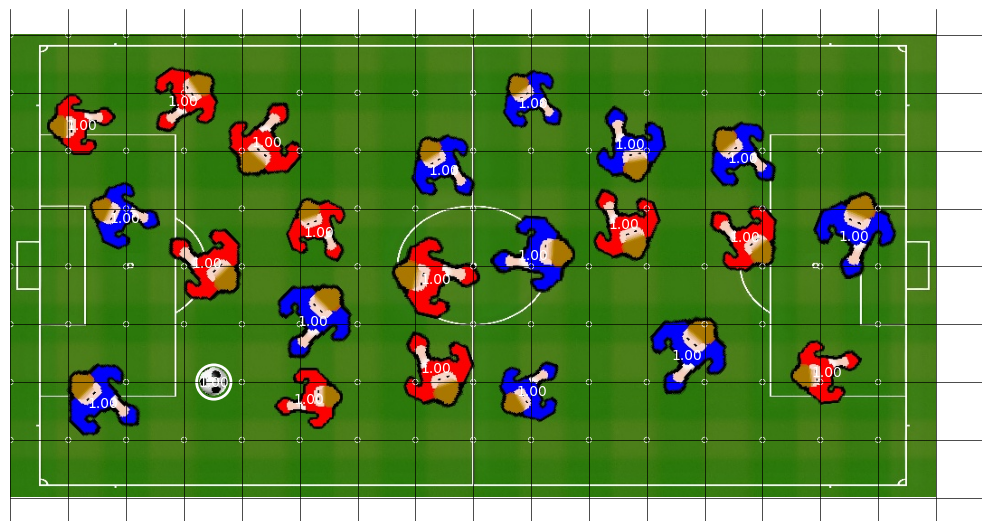

torch.Size([8, 16, 1, 8])
torch.Size([1, 8, 16, 1, 8])


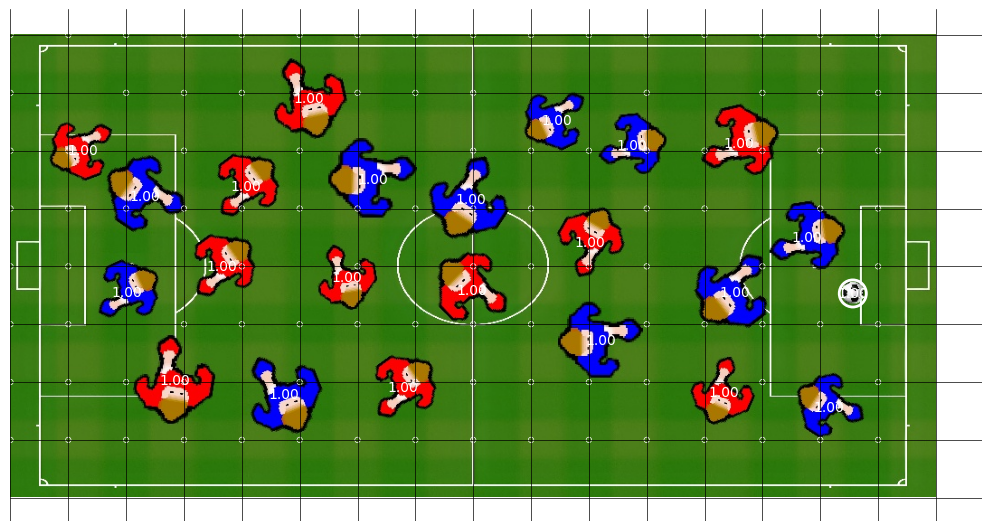

In [8]:
for idx, image in images_train.sample(n=2).iterrows():
    image_encoded, image_pxl = preprocessImage(image['image'], device)
    print(image['annotation'].shape)
    annotation = image['annotation'].unsqueeze(0)
    print(annotation.shape)
    drawImage(image_pxl, annotation, grid_H, grid_W)

### YOLO simplified Example 

In [18]:
class AsymmetricYOLO(nn.Module):
    def __init__(self, imageWidth = 1024, imageHeight = 512, W=32, H=16, B=3, C=3, device = device):
        super(AsymmetricYOLO, self).__init__()
        self.device     = device
        self.imageWidth = imageWidth
        self.imageHeight= imageHeight
        self.W          = W # Width of Grid
        self.H          = H # Height of Grid
        self.B          = B # How many boxes in Grid Cell to search
        self.C          = C # Amount of Classes (Red Player, Blue Player, Ball)
        self.BoxSize    = 5
        
        self.input_channels     = 3     # The number of input channels. For RGB images, this is 3.
        self.first_output_channels = 8  # Output channels for the first conv layer.
        self.second_output_channels = 16  # New layer's output channels.
        self.third_output_channels = 64  # New layer's output channels.
        self.kernel_size        = 5    # The size of the filter applied to the input image. A size of 3 means a 3x3 filter.
        self.stride             = 1   # The stride of the convolution. A stride of 1 means the filter moves one pixel at a time as it slides across the image.
        
        # Padding added to the edges of the input. A padding of 1 adds a one-pixel border of zeros around the input image, 
        # allowing the output size to be the same as the input size when using a stride of 1 and a 3x3 kernel.
        self.padding            = 0   
        
        # Define the CNN architecture
        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                self.input_channels, 
                self.first_output_channels, 
                kernel_size=5, 
                stride=1, 
                padding=1
            ),
            nn.BatchNorm2d(self.first_output_channels),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Add more convolutional layers as needed
            nn.Conv2d(
                self.first_output_channels,
                self.second_output_channels,
                kernel_size=3,
                stride=1,
                padding=self.padding
            ),
            nn.BatchNorm2d(self.second_output_channels),
            nn.LeakyReLU(0.1),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(
            #     self.second_output_channels, 
            #     self.third_output_channels, 
            #     kernel_size=3, 
            #     stride=1, 
            #     padding=self.padding
            # ),
            # nn.BatchNorm2d(self.third_output_channels),
            # nn.LeakyReLU(0.1),
        ).to(self.device)

        # Assuming the feature map size here is compatible with the input image size
        # feature_size = 512 * 256 * self.output_channels
        # and grid size after the convolutions and pooling

        # Temporarily forward a dummy input through the conv_layers to find feature_size
        dummy_input = torch.autograd.Variable(torch.rand(1, 3, imageWidth, imageHeight)).to(self.device)
        output_feat = self.conv_layers(dummy_input)
        feature_size = int(np.prod(output_feat.size()[1:]))  # Multiply dimensions for feature size

        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_size, W * H * B * (C + self.BoxSize)),  # Adjust 'feature_size' based on the output of the last conv layer
            nn.LeakyReLU(0.1),
        ).to(self.device)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layer(x)
        x = x.view(-1, self.H, self.W, self.B , (self.C +  self.BoxSize))  # Reshape to match the grid size and predictions
        return x

### Dataset


In [19]:
class SportsDataset(Dataset):
    def __init__(self, images, num_classes, imageWidth, imageHeigh, grid_W, grid_H, B, device):
        self.images = images
        self.num_classes = num_classes
        self.grid_W = grid_W
        self.grid_H = grid_H
        self.imageWidth = imageWidth
        self.imageHeigh = imageHeigh
        self.device = device
        self.B = B

    def __len__(self):
        return len(self.images)
    
    def normalization(self, image):
        
         # Normalize pixel values
        image   = image / 255.0  # Scale pixels to [0, 1]
        
        # Manually normalize the image using specified means and stds
        # mean    = np.array([0.485, 0.456, 0.406])
        # std     = np.array([0.229, 0.224, 0.225])
        # image   = (image - mean) / std  # Apply normalization
        
        return image

    def __getitem__(self, idx):
        images_row = self.images.iloc[idx]
        
        # Decode image from binary data
        image = cv2.imdecode(np.frombuffer(images_row['image'], np.uint8), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        image = self.normalization(image)
        images = torch.tensor(image, dtype=torch.float32, device = self.device).permute(2, 0, 1)

        return images, images_row['annotation']


# Loss Function

In [20]:
def intersection_area_ratio(x1, y1, R1, x2, y2, R2):
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    total_area = np.pi * (R1**2 + R2**2)
    if d >= (R1 + R2):
        # The circles do not intersect
        return 0
    elif d <= abs(R1 - R2):
        # One circle is completely inside the other
        return (np.pi * min(R1, R2)**2) / total_area
    else:
        # The circles intersect
        term1 = (R1**2) * np.arccos((d**2 + R1**2 - R2**2) / (2 * d * R1))
        term2 = (R2**2) * np.arccos((d**2 + R2**2 - R1**2) / (2 * d * R2))
        term3 = 0.5 * np.sqrt((-d + R1 + R2) * (d + R1 - R2) * (d - R1 + R2) * (d + R1 + R2))
        return (term1 + term2 - term3) / total_area

def distance(x1, y1, x2, y2):
    d = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return d

def intersection_area_ratio_torch(x1, y1, R1, x2, y2, R2):
    d = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    total_area = torch.pi * (R1**2 + R2**2)
    if d >= (R1 + R2):
        # The circles do not intersect
        return torch.tensor(0.0)
    elif d <= torch.abs(R1 - R2):
        # One circle is completely inside the other
        return (torch.pi * torch.min(torch.tensor([R1, R2]))**2) / total_area
    else:
        # The circles intersect
        term1 = (R1**2) * torch.acos((d**2 + R1**2 - R2**2) / (2 * d * R1))
        term2 = (R2**2) * torch.acos((d**2 + R2**2 - R1**2) / (2 * d * R2))
        term3 = 0.5 * torch.sqrt((-d + R1 + R2) * (d + R1 - R2) * (d - R1 + R2) * (d + R1 + R2))
        intersection_area = term1 + term2 - term3
        return intersection_area / total_area
    
def resortPredictionByTargetAreaRatio(target, predictions):
    for i in range(target.shape[0]):  # Loop through the first dimension
        for j in range(target.shape[1]):  # Loop through the second dimension
            for k in range(target.shape[2]):  # Loop through the third dimension
                for g in range(target.shape[3]):  # Loop through the fours dimension
                    if(target[i, j, k, g, 0] == 0 ):
                        break;
                    
                    nearest_prediction_object_index = g
                    biggest_inters_area_ratio = 0
                    for m in range(g, predictions.shape[3]):  # Loop through the fours dimension
                        ratio = intersection_area_ratio_torch(
                            x1 = target[i, j, k, g, 1],
                            y1 = target[i, j, k, g, 2],
                            R1 = target[i, j, k, g, 3],
                            x2 = predictions[i, j, k, g, 1],
                            y2 = predictions[i, j, k, g, 2],
                            R2 = predictions[i, j, k, g, 3],
                        )
                        
                        if ratio > biggest_inters_area_ratio:
                            biggest_inters_area_ratio = ratio
                            nearest_prediction_object_index = m
                    
                    if nearest_prediction_object_index != g:
                        predictions[i, j, k, [g, nearest_prediction_object_index], :] = predictions[i, j, k, [nearest_prediction_object_index, g], :]
    return predictions

In [21]:
def lossPlayerFunction(
        predictions, 
        target, 
        lambda_coord=5,     # lambda_coord: Weight for the coordinate loss component.
        lambda_noobj=0.5,
        lambda_orientation = 1   # Orientation hyper parametr.
    ):


    batch_size = predictions.shape[0]
    
    # batch structure [100, 8, 16, 3, 8] -> [Batch_size, grid_H, grid_W, B, Box]
    # Box structure [Confident, x, y, radius, orientation, [one, hot, class]]
    
    # predictions = resortPredictionByTargetAreaRatio(target, predictions)

    coord_loss              = 0 
    radius_loss             = 0
    orientation_loss        = 0
    object_exist_loss       = 0
    object_not_exist_loss   = 0
    class_loss              = 0

    # objects generated in one image
    total_objects = 0
    total_noobjects = 0

    for i in range(predictions.shape[0]):  # Loop through the first dimension
        for j in range(predictions.shape[1]):  # Loop through the second dimension
            for k in range(predictions.shape[2]):  # Loop through the third dimension
                for g in range(predictions.shape[3]):  # Loop through the fours dimension
                    
                    coord_loss_item             = 0
                    radius_loss_item            = 0
                    orientation_loss_item       = 0
                    object_exist_loss_item      = 0
                    object_not_exist_loss_item  = 0
                    class_loss_item             = 0    
                    
                    best_g_p = 0
                    if(target[i, j, k, best_g_p, 0].item() == 1 ):
                        total_objects += 1
                        # X, Y loss for the Coordinates of the center of boxes
                        coord_loss_item = ((target[i, j, k, best_g_p, 1] - predictions[i, j, k, g, 1])**2 + (target[i, j, k, best_g_p, 2] - predictions[i, j, k, g, 2])**2)
                        coord_loss += coord_loss_item
                        # OBJECT HERE loss - only for boxes that are responsible for detecting objects
                        object_exist_loss_item = ((target[i, j, k, best_g_p, 0] - predictions[i, j, k, g, 0])**2)
                        object_exist_loss += object_exist_loss_item
                    
                        # CLASS loss for the class probabilities of each grid cell
                        class_loss_item = torch.sum((target[i, j, k, best_g_p, 5:] - predictions[i, j, k, g, 5:])**2)
                        class_loss += class_loss_item

                        # RADIUS for the dimensions of boxes (sqrt is applied to emphasize smaller boxes)
                        pred_signs = torch.sign(predictions[i, j, k, g, 3])
                        radius_loss_item = torch.sum((target[i, j, k, best_g_p, 3].sqrt() - pred_signs * predictions[i, j, k, g, 3].abs().sqrt())**2)
                        radius_loss += radius_loss_item

                        # ORIENTATION loss for the Coordinates of the center of boxes
                        orientation_loss_item = ((target[i, j, k, best_g_p, 4] - predictions[i, j, k, g, 4])**2)
                        orientation_loss += orientation_loss_item

                    else:
                        total_noobjects += 1
                        # NO OBJECT loss - for boxes that are not responsible for detecting objects
                        # Typically, this has a lower weight (lambda_noobj) because there are many more negative (no-object) examples
                        object_not_exist_loss_item = torch.sum((target[i, j, k, best_g_p, 0] - predictions[i, j, k, g, 0])**2)
                        object_not_exist_loss += object_not_exist_loss_item
    
    # Total loss
    total_loss = coord_loss * lambda_coord /total_objects
    + radius_loss * lambda_coord /total_objects
    + orientation_loss * lambda_orientation / total_objects
    + object_exist_loss / total_objects
    + object_not_exist_loss * lambda_noobj / total_noobjects
    + class_loss
    return total_loss / batch_size # Normalize by batch size for consistency

In [22]:
def lossPlayerTorchFunction(
        predictions, 
        target,
        lambda_coord=5,     # lambda_coord: Weight for the coordinate loss component.
        lambda_noobj=0.5,
        lambda_orientation = 1,   # Orientation hyper parametr.  
    ):
    
    batch_size = predictions.shape[0]    
    
    # batch structure [100, 8, 16, 3, 8] -> [Batch_size, grid_H, grid_W, B, Box]
    # Box structure [Confident, x, y, radius, orientation, [one, hot, class]]

    mse_loss = torch.nn.MSELoss(reduction="none")
    
    # Assume target tensor follows the same channel organization as output
    # object_mask to identify cells with an object.
    
    object_mask = target[..., 0] > 0  # Using the object confidence score > 0 as an indicator.
    
    # Coordinate loss for cells with objects
    # Adjusting coordinate loss to match the specified indexes
    # Extracting the specific coordinates from the tensors
    pred_signs = torch.sign(predictions[object_mask][..., 3])
    x_loss = mse_loss(predictions[object_mask][..., 1], target[object_mask][..., 1])  # Loss for x coordinate
    y_loss = mse_loss(predictions[object_mask][..., 2], target[object_mask][..., 2])  # Loss for y coordinate
    radius_loss = mse_loss(pred_signs*predictions[object_mask][..., 3].abs().sqrt(), target[object_mask][..., 3].sqrt())  # Loss for width
    

    # Combining the losses for coordinates
    coord_loss = lambda_coord * (
        x_loss + y_loss 
        + radius_loss 
    ).sum() / object_mask.sum()
    
    orientation_loss = mse_loss(predictions[object_mask][..., 4], target[object_mask][..., 4]).sum() / object_mask.sum()  # Loss for height

     # Object loss (confidence score where there's an object)
    obj_loss = mse_loss(predictions[object_mask][..., 0], target[object_mask][..., 0]).sum() / object_mask.sum()
    
    # No-object loss (confidence score where there's no object)
    noobj_mask = ~object_mask
    noobj_loss = lambda_noobj * mse_loss(predictions[noobj_mask][..., 0], target[noobj_mask][..., 0]).sum() / noobj_mask.sum()
    
    # Combining the losses
    total_loss = (
        coord_loss 
        # + orientation_loss
        + obj_loss 
        + noobj_loss
    )
    return total_loss


Epochs and Dataloader

In [23]:
batch_size=16
lr=0.0001
epochs = 10

ImagesDataset = SportsDataset(images_train, num_classes, imageWidth, imageHeigh, grid_W, grid_H, B, device)
ImagesDataLoader = DataLoader(ImagesDataset, batch_size, shuffle=False)

### Yolo Run

In [24]:
Yolo = AsymmetricYOLO(
    imageWidth = imageWidth,
    imageHeight = imageHeigh,
    W = grid_W, 
    H = grid_H, 
    B = B, 
    C = num_classes, 
    device = device,
).to(device)

optimizer = torch.optim.Adam(Yolo.parameters(), lr)



RuntimeError: MPS backend out of memory (MPS allocated: 17.77 GB, other allocations: 18.75 MB, max allowed: 18.13 GB). Tried to allocate 7.86 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

### Train

In [16]:
batch_loss_history = []
for epoch in range(epochs):
    Yolo.train()
    running_loss = 0.0
    for batch_idx, (batch_images, batch_annotations) in enumerate(ImagesDataLoader):
        optimizer.zero_grad()
        outputs = Yolo(batch_images)
        # loss = lossPlayerFunction(
        #     outputs, 
        #     batch_annotations,
        #     lambda_coord=5,     # lambda_coord: Weight for the coordinate loss component.
        #     lambda_noobj=0.5,
        #     lambda_orientation = 1 
        # )

        loss = lossPlayerTorchFunction(
            outputs, 
            batch_annotations, 
            lambda_coord=5,     # lambda_coord: Weight for the coordinate loss component.
            lambda_noobj=0.5,
            lambda_orientation = 1 
        )
        loss.backward()
        optimizer.step()
        batch_loss_history.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(ImagesDataLoader)}], Loss: {loss.item()}")
        # break;
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()} Running Loss:  {running_loss / len(ImagesDataLoader)}")
    # break;
    # After training, plot the batch loss history
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(batch_loss_history, label='Batch Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Loss Over Batches')
plt.legend()
plt.show()
    

RuntimeError: MPS backend out of memory (MPS allocated: 17.77 GB, other allocations: 306.75 MB, max allowed: 18.13 GB). Tried to allocate 125.76 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# Preprocesss one image

In [ ]:

Yolo.eval()
with torch.no_grad():
     random_images = images_test.sample(n=2)
     for image in random_images.iterrows():
          image_preprocessed, source_image = preprocessImage(image[1]['image'], device)
          output = Yolo(image_preprocessed.unsqueeze(0))
          # print(output.shape)
          # print(output)
          drawImage(source_image, output, grid_H, grid_W, hideUnconfident = False)

          

# `output` now contains the model's predictions for the input image